In [8]:
import os
import covid19 as c19
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from jax.nn import softplus
import jax.numpy as jnp
from jax import random

import scipy.stats as stats
from jax.nn import sigmoid
from jax.ops import index_update, index
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
LAD = c19.get_geodata()
specimen = pd.read_csv('newest_data/specimen-201227.csv', index_col=0)
deaths = pd.read_csv('newest_data/death-201227.csv', index_col=0)
lineage = pd.read_csv('newest_data/lineage_weeks_ltla_28122020.csv', index_col=0)
# prepare data
strain = (
    lineage
    .loc[:, ['WeekEndDate'] + [ i for i in lineage.columns.tolist() if i.endswith('Lineage') ]]
    .rename(columns=lambda x: x.rstrip('_Lineage') if x.endswith('_Lineage') else x)
    .set_index('WeekEndDate')).T
other = (
    lineage
    .loc[:, ['WeekEndDate'] + [ i for i in lineage.columns.tolist() if i.endswith('Other') ]]
    .rename(columns=lambda x: x.rstrip('_Other') if x.endswith('_Other') else x)
    .set_index('WeekEndDate')).T

# genrate arrays
specimen = (
    LAD
    .merge(specimen.iloc[:, -118:].reset_index(), left_on='lad19cd', right_on='index', how='left')
    .iloc[:, -118:-5].values)
deaths = (
    LAD
    .merge(deaths.iloc[:, -118:].reset_index(), left_on='lad19cd', right_on='index', how='left')
    .iloc[:, -118:-5].values)
strain = (
    LAD
    .merge(strain.reset_index(), left_on='lad19cd', right_on='index', how='left')
    .iloc[:, -12:].values)
other = (
    LAD
    .merge(other.reset_index(), left_on='lad19cd', right_on='index', how='left')
    .iloc[:, -12:]
    .values)
total = strain + other

In [3]:
specimen.shape

(382, 113)

In [4]:
S = np.where(~np.isnan(strain[:,1]))[0] # which locations do have strain data available
U = LAD.utla19id.values
C = LAD.ctry19id.values
N = LAD.pop18.values
_, B_forecast, Bdiff_forecast = c19.create_spline_basis(np.arange(specimen.shape[1]), num_knots = 8)

B = B_forecast[:113,:]
Bdiff = Bdiff_forecast[:113, :]

In [5]:
dates = pd.DataFrame({'date': [ str(d)[:10] for d in pd.date_range(start='2020-09-01', end='2021-01-02')], 'x': np.arange(124)})
strain_times = dates[dates.date.isin(lineage.WeekEndDate)]['x'].values
X = np.stack([np.ones_like(strain_times), strain_times]).T
X_specimen_forecast = np.stack([np.ones_like(dates.x.values), dates.x.values]).T
X_specimen = X_specimen_forecast[:113, :]

In [6]:
strain_times

array([ 26,  33,  40,  47,  54,  61,  68,  75,  82,  89,  96, 103])

In [7]:
S.shape

(246,)

In [8]:
def plot(idx):
    d = pd.date_range(start='2020-09-01', periods=specimen.shape[1], freq='d').to_pydatetime().tolist()    
    d2 = pd.to_datetime(lineage['WeekEndDate']).tolist()
    d3 = pd.date_range(start='2020-11-01', end='2020-12-22').to_pydatetime().tolist()
    fig, ax = plt.subplots(3, 1, figsize=(6, 6))
    ax[0].plot(d, specimen[idx], '.', label='data')
    ax[0].plot(d, svi.mean('λ')[idx], label='total', color='C1')
    ax[0].fill_between(d, svi.lower('λ')[idx], svi.upper('λ')[idx], alpha=.2, color='C1')
    ax[0].set_ylabel('New cases')
    if idx in S:
        ax[0].plot(d, svi.mean('λ_strain')[idx], label='B.1.1.7', color='C3')
        ax[0].fill_between(d, svi.lower('λ_strain')[idx], svi.upper('λ_strain')[idx], alpha=.2, color='C3')
        ax[0].plot(d, svi.mean('λ_base')[idx], label='other lineages', color='C2')
        ax[0].fill_between(d, svi.lower('λ_base')[idx], svi.upper('λ_base')[idx], alpha=.2, color='C2')
    ax[0].legend()
    ax[0].set_xticklabels([])
    ax[0].set_title(LAD.loc[idx, 'lad19nm'], fontsize=16)
    if idx in S:
        ax2 = ax[1].twinx()
        ax2.set_ylabel('Total genomes', color='C7')
        ax2.bar(d2, total[idx], label='total', width=2, color='C7', alpha=.5)
        #ax2.legend(loc='upper left')
        ax2.set_xticklabels([])
        ax[1].plot(d2, svi.mean('p')[idx][strain_times], color='C3')
        ax[1].fill_between(d2, svi.lower('p')[idx][strain_times], svi.upper('p')[idx][strain_times], color='C3', alpha=.2)
        ax[1].plot(d2, strain[idx]/total[idx], 'o', color='C3', label='data')
        ax[1].set_xlim(*ax[0].get_xlim())
        ax[1].set_ylim([0, 1])
        ax[1].set_ylabel('Fraction B.1.1.7')
        ax[1].set_zorder(ax2.get_zorder()+1)
        ax[1].patch.set_visible(False)
        ax[1].legend(loc='upper left')
    #ax[2].plot(d, svi.mean('R')[idx], color='C1', )
    #ax[2].fill_between(d, svi.lower('R')[idx], svi.upper('R')[idx], alpha=.2, color='C1')
    if idx in S:
        skip_last = 6
        ax[2].plot(d3[:-skip_last], svi.mean('R_strain')[idx][61:-skip_last], color='C3', label="B.1.1.7")
        ax[2].fill_between(d3[:-skip_last], svi.lower('R_strain')[idx][61:-skip_last], svi.upper('R_strain')[idx][61:-skip_last], alpha=.2, color='C3')
        ax[2].plot(d[:-skip_last], svi.mean('R_base')[idx][:-skip_last], color='C2', label="other lineages")
        ax[2].fill_between(d[:-skip_last], svi.lower('R_base')[idx][:-skip_last], svi.upper('R_base')[idx][:-skip_last], alpha=.2, color='C2')
    ax[2].set_ylim([.5, 3])
    ax[2].axvspan(d[65], d[92], color='C7', alpha=.2)
    ax[2].grid(True)    
    ax[2].set_ylabel(r'$R$ value')
    ax[2].legend(loc='upper left')
    ax[2].text(d[79], ax[2].get_ylim()[1]*.98, "lockdown", ha = 'center', va='top')
    ax[2].axhline(1, linestyle='--', color='k')
    ax[2].set_xlim(*ax[0].get_xlim())
    plt.gcf().autofmt_xdate()

In [11]:
relaxed = RelaxedStrainModel()

In [12]:
svi = c19.SVIHandler(relaxed.model, relaxed.guide, rng_key=3253, optimizer=npy.optim.ClippedAdam, lr=0.01, num_samples=1000, num_epochs=2000)
#svi = c19.SVIHandler(relaxed.model, relaxed.guide, rng_key=845, optimizer=npy.optim.ClippedAdam, lr=0.001, num_samples=2000, num_epochs = 20000)

In [13]:
svi.fit(B, Bdiff, strain_times, S, C, U, N, specimen, strain[S], total[S], log_freq=0)

In [14]:
svi.loss

DeviceArray([1740185.1 , 1404267.4 , 1539693.2 , ...,  160655.94,
              159570.  ,  159238.67], dtype=float32)

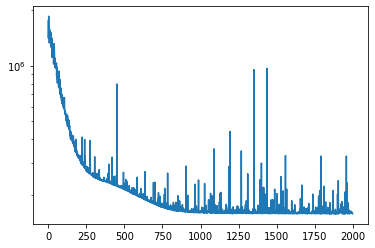

In [15]:
plt.semilogy(svi.loss)

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


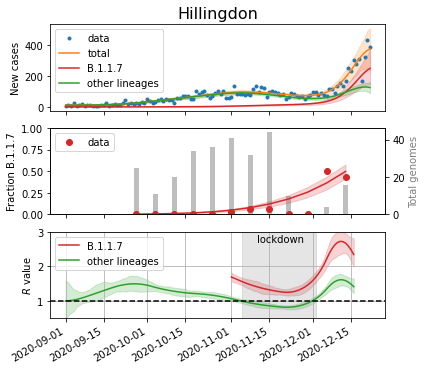

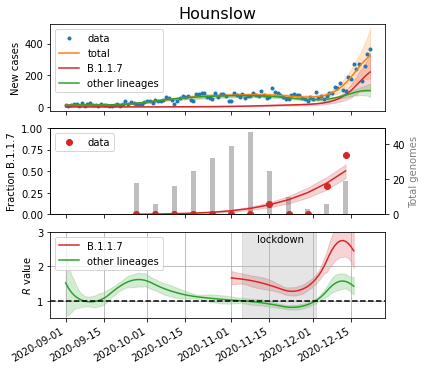

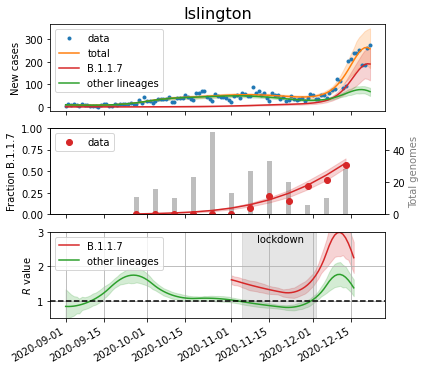

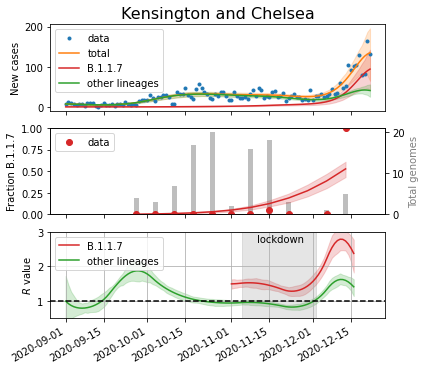

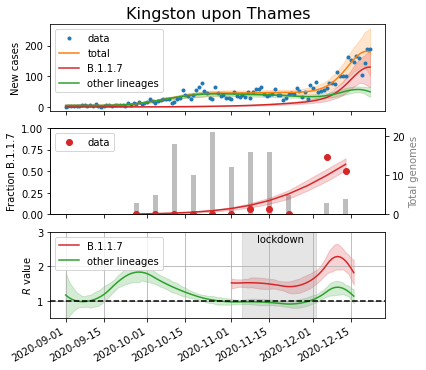

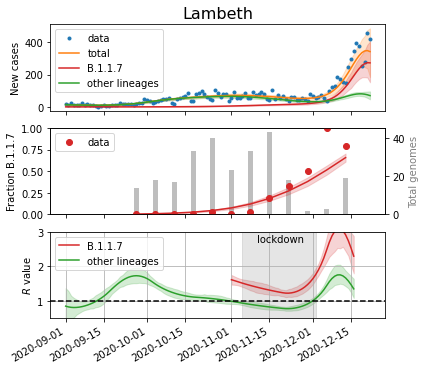

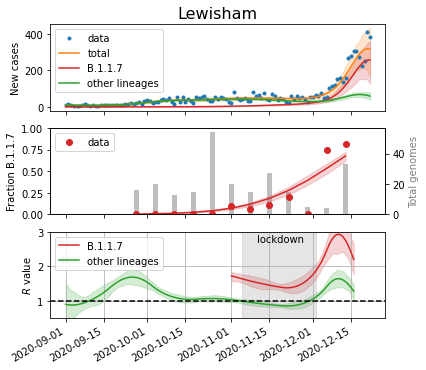

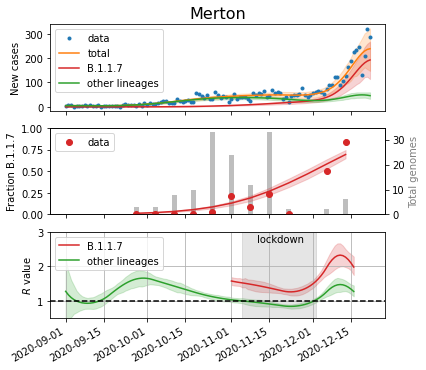

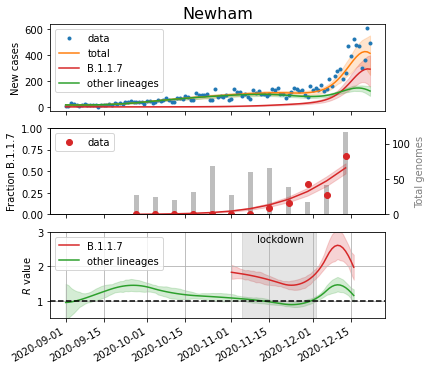

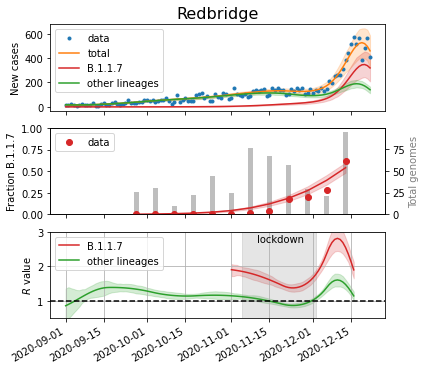

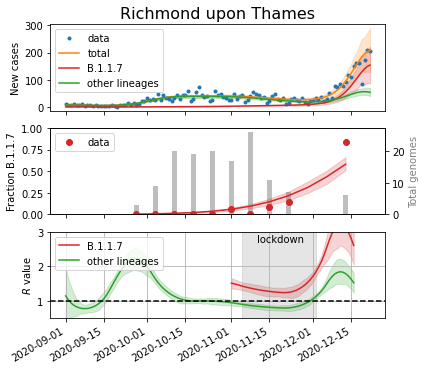

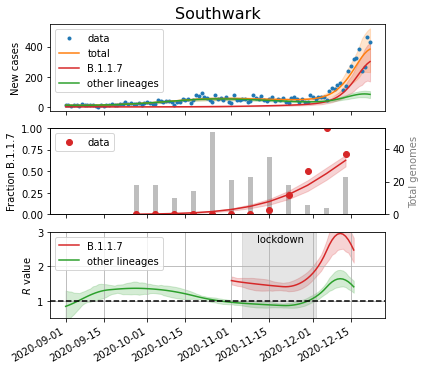

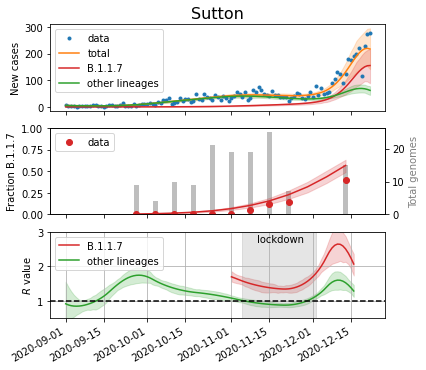

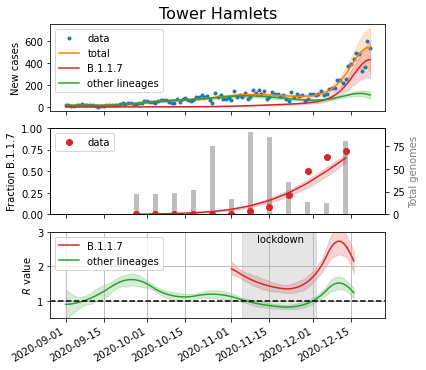

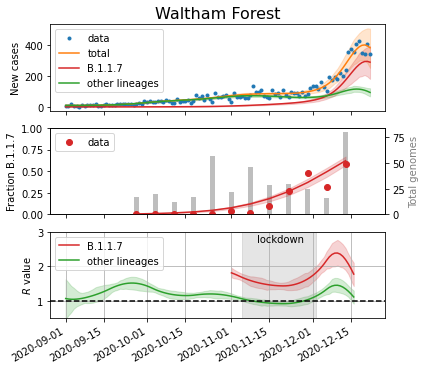

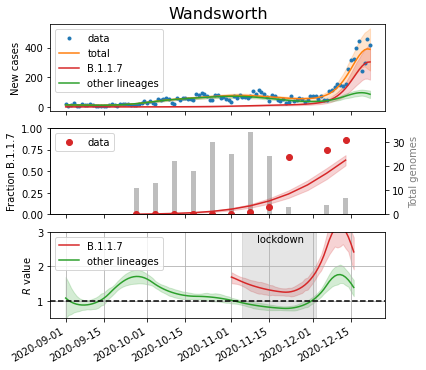

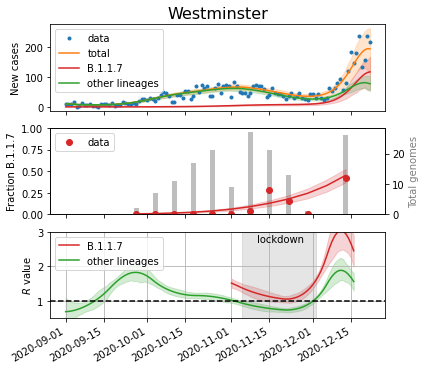

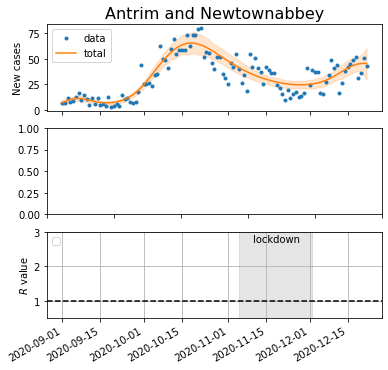

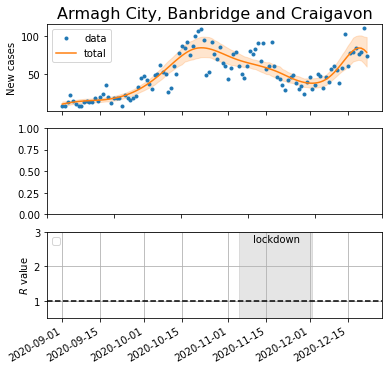

In [16]:
for i in range(300,319):
    try:
        plot(i)
    except:
        pass

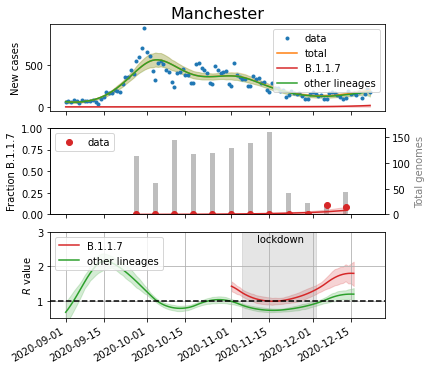

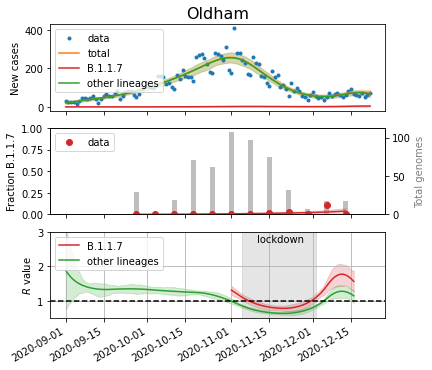

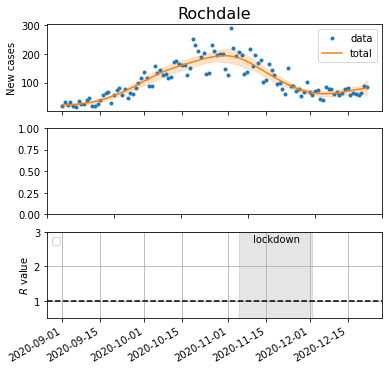

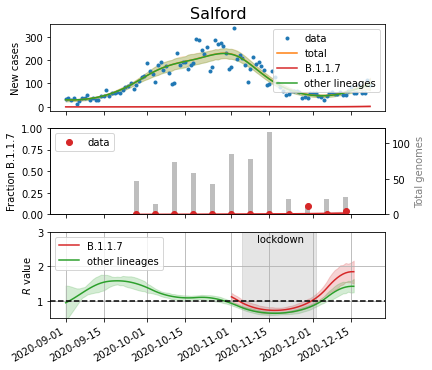

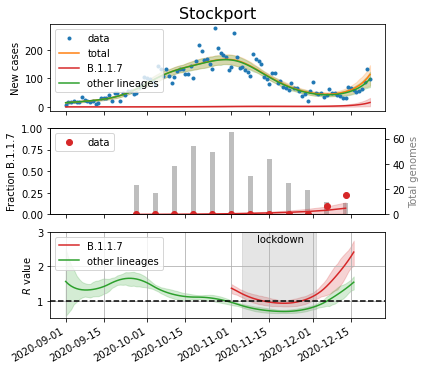

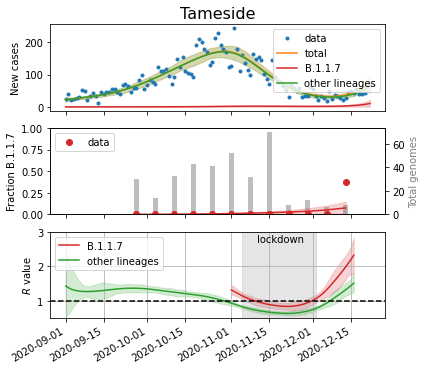

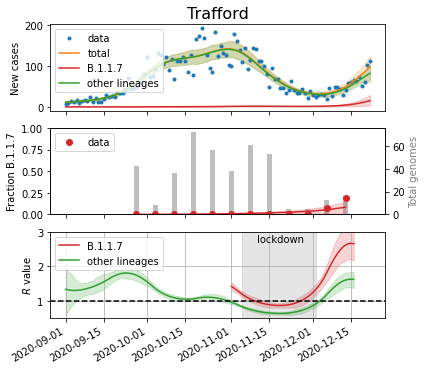

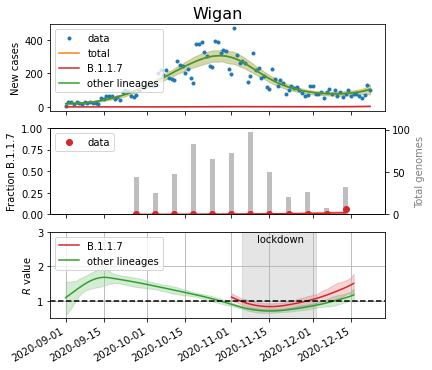

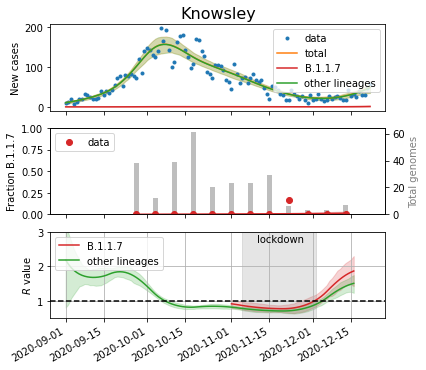

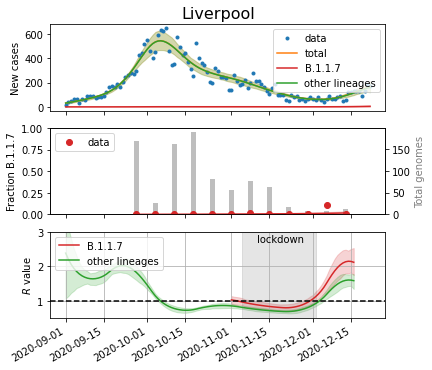

In [17]:
for i in range(250,260):
    try:
        plot(i)
    except:
        pass

In [18]:
np.where(LAD.lad19nm.values == "Thurrock")

(array([31]),)

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


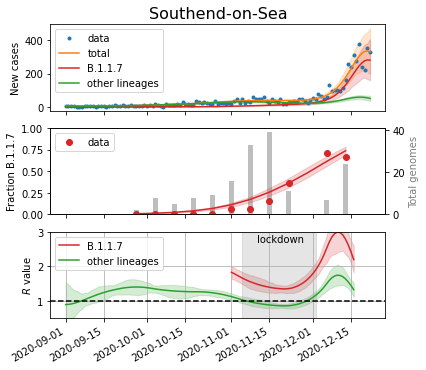

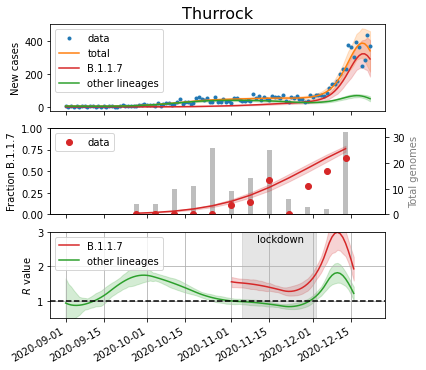

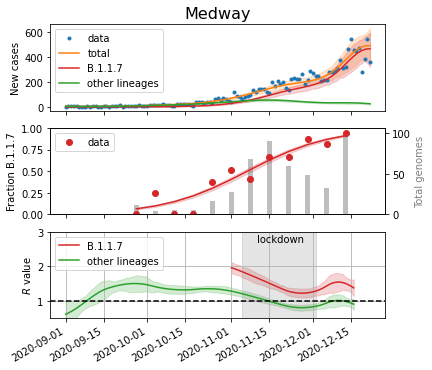

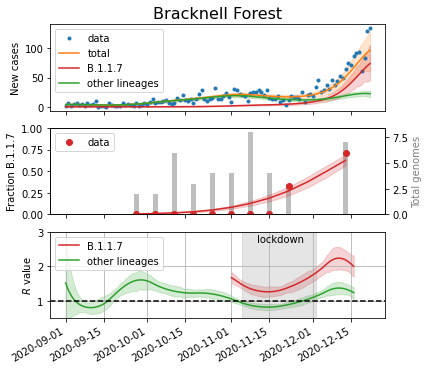

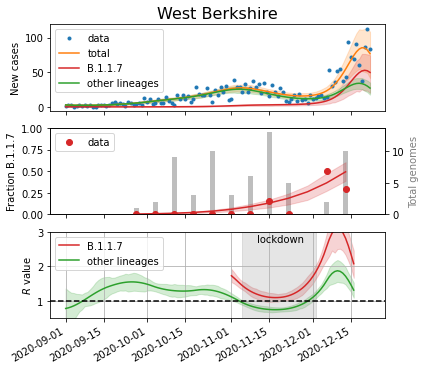

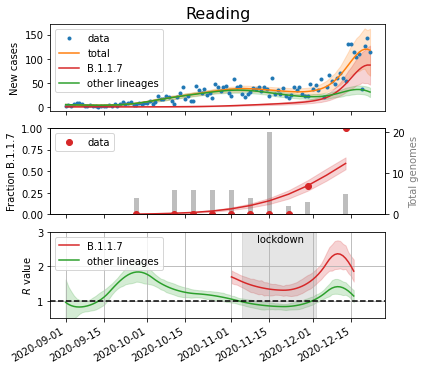

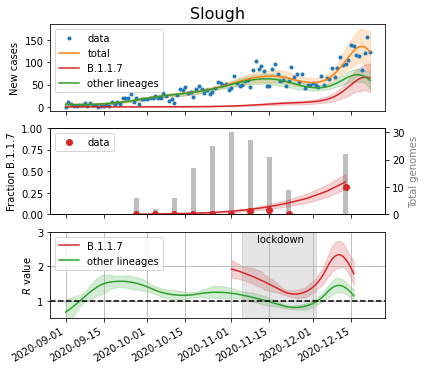

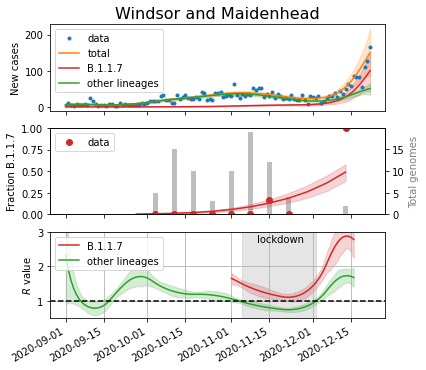

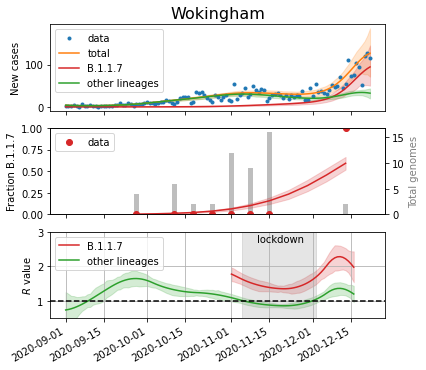

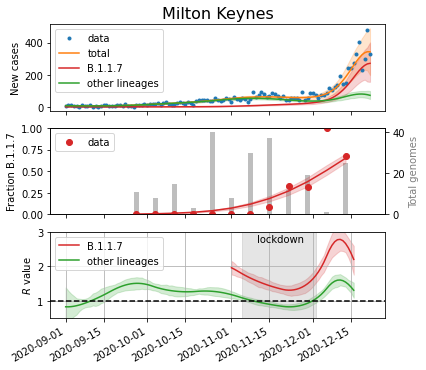

In [19]:
for i in range(30,40):
    try:
        plot(i)
    except:
        pass

In [20]:
np.where(LAD.lad19nm.values == "Cambridge")

(array([60]),)

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


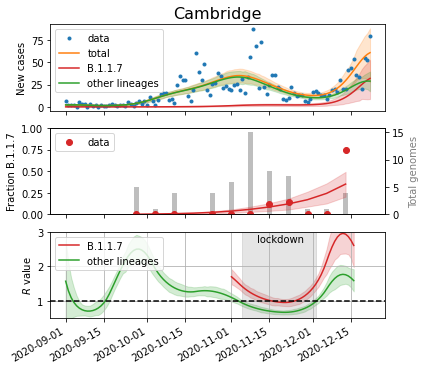

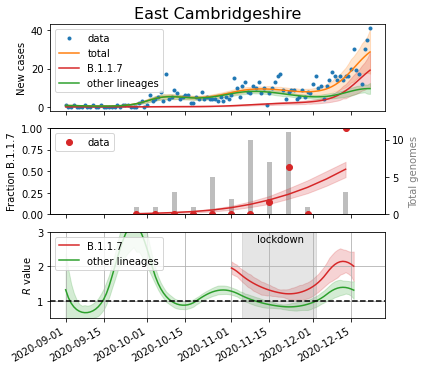

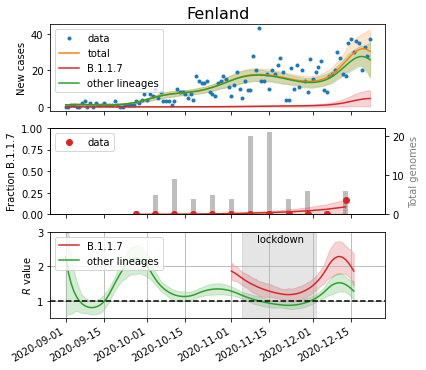

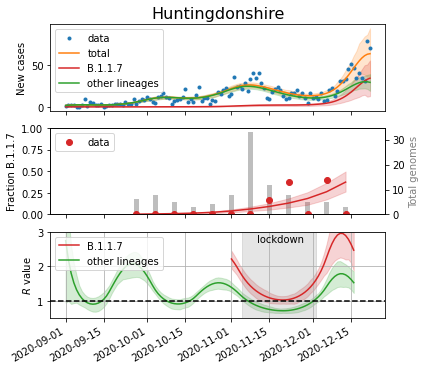

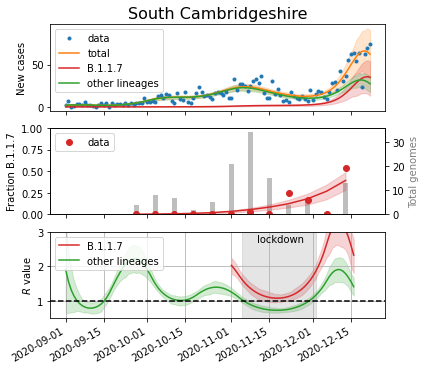

In [21]:
for i in range(60,65):
    try:
        plot(i)
    except:
        pass

In [22]:
R_lockdown0min = np.delete(svi.posterior['R_base'][:,:,65:92].mean(0).min(1), S)
R_lockdownmin = np.array([svi.posterior['R_base'][:,S,65:92].mean(0).min(1), 
            svi.posterior['R_strain'][:,S,65:92].mean(0).min(1)])

In [23]:
(R_lockdownmin > 1).mean(1)

array([0.00406504, 0.64227642])

<Figure size 432x288 with 0 Axes>

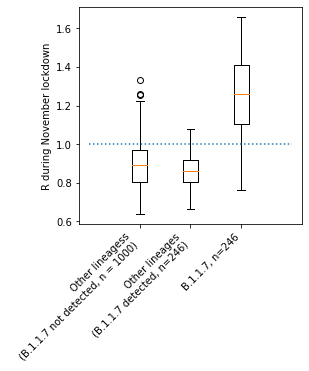

<Figure size 432x288 with 0 Axes>

In [24]:
R_lockdown0 = np.delete(svi.posterior['R_base'][:,:,65:92].mean(2), S, axis=1)
R_lockdown = np.array([svi.posterior['R_base'][:,S,65:92].mean(2), 
            svi.posterior['R_strain'][:,S,65:92].mean(2)])
w = strain[S,:].sum(1)>0
plt.figure(figsize=(4,4))
plt.boxplot([R_lockdown0.mean(0), R_lockdown.mean(1)[0,w], R_lockdown.mean(1)[1,w]], positions=range(3))
plt.xticks(range(3), labels = [f"Other lineagess\n (B.1.1.7 not detected, n = {len(R_lockdown0)})", f"Other lineages\n (B.1.1.7 detected, n={len(S)})", f"B.1.1.7, n={len(S)}"], 
           rotation=45, ha="right")
plt.ylabel("R during November lockdown")
plt.plot([-1,3], [1,1], ":")
plt.figure(facecolor="white")
#plt.boxplot()

In [25]:
R_lockdown.shape

(2, 1000, 246)

In [26]:
np.quantile(R_lockdown[0,:], [.25,.5,.75])

array([0.79742572, 0.86043689, 0.92293559])

In [27]:
np.quantile(R_lockdown[1,:], [.25,.5,.75])

array([1.09777027, 1.25832355, 1.4118821 ])

In [28]:
(R_lockdownmin[1,:] > 1 ).mean()

0.6422764227642277

In [29]:
def pivot_table(X, v):
    return np.array([(X==vv).sum() for vv in v])

In [30]:
w = strain[S,:6].sum(1)>-1
escape =  (R_lockdown > 1 )
e = np.einsum('i,ijk',np.arange(1,3), escape)
p = np.array([pivot_table(X, range(4)) for X in e[...,w]])

([<matplotlib.axis.XTick at 0x7fc8d5a396d0>,
 [Text(1, 0, 'Both controlled'),
  Text(2, 0, 'Only other lineages escape'),
  Text(3, 0, 'Only B.1.1.7 escapes'),
  Text(4, 0, 'All escape')])

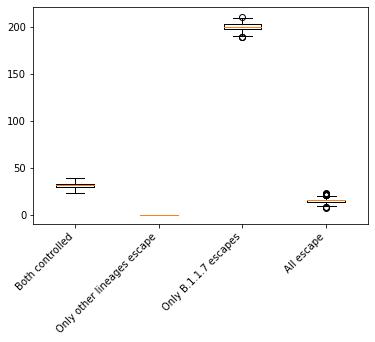

In [31]:
plt.boxplot(p)
plt.xticks(range(1,5), labels = ["Both controlled", "Only other lineages escape", "Only B.1.1.7 escapes", "All escape"], 
           rotation=45, ha="right")

In [32]:
q = np.quantile(p,[.025,.5,.975], axis=0)
q

array([[ 25.,   0., 193.,  10.],
       [ 31.,   0., 200.,  15.],
       [ 36.,   0., 208.,  20.]])

Text(0, 0.5, 'Number of LTLAs')

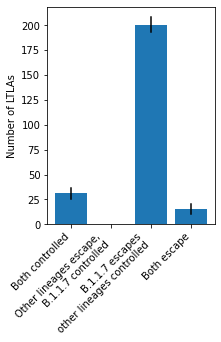

In [33]:
plt.figure(figsize=(3,4))
plt.bar(np.arange(4), q[1,:])
for i in range(4):
    plt.plot([i,i], q[::2,i], c='black')
plt.xticks(range(4), labels = ["Both controlled", "Other lineages escape,\n B.1.1.7 controlled", "B.1.1.7 escapes\nother lineages controlled", "Both escape"], 
           rotation=45, ha="right")
plt.ylabel("Number of LTLAs")

In [34]:
np.quantile(p,[.025,.5,.975], axis=0)/S.shape[0]


array([[0.10162602, 0.        , 0.78455285, 0.04065041],
       [0.12601626, 0.        , 0.81300813, 0.06097561],
       [0.14634146, 0.        , 0.84552846, 0.08130081]])

Text(0.99, 0.01, 'B.1.1.7 controlled\nother escaped')

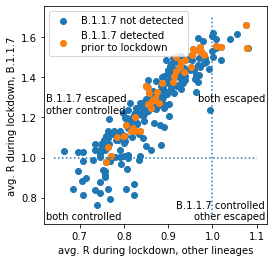

In [35]:
w = np.where(strain[S,:6].sum(1)>0)[0]
plt.figure(facecolor="white", figsize=(4,4))
ax = plt.axes()
plt.scatter(R_lockdown.mean(1)[0,], R_lockdown.mean(1)[1,], label="B.1.1.7 not detected")
plt.scatter(R_lockdown.mean(1)[0,w], R_lockdown.mean(1)[1,w], label="B.1.1.7 detected\nprior to lockdown")
plt.legend()
plt.xlabel("avg. R during lockdown, other lineages")
plt.ylabel("avg. R during lockdown, B.1.1.7")
#plt.plot([.5,1.5], [.5, 1.5],":")
plt.plot(ax.get_xlim(), [1,1],":", c="C0")
plt.plot([1, 1], ax.get_ylim(),":", c="C0")
plt.text(0.01, 0.01, 'both controlled', ha='left',va="bottom", transform=ax.transAxes)
plt.text(0.01, .6, 'B.1.1.7 escaped\nother controlled', ha='left',va="top", transform=ax.transAxes)
plt.text(0.99, 0.6, 'both escaped', ha='right',va="top", transform=ax.transAxes)
plt.text(0.99, 0.01, 'B.1.1.7 controlled\nother escaped', ha='right',va="bottom", transform=ax.transAxes)
#plt.plot([.5,1.5], np.array([.5, 1.5])**1.05)

In [36]:
w

array([  2,  11,  12,  22,  23,  24,  34,  64,  66,  85,  89,  96,  97,
        98,  99, 100, 101, 102, 104, 105, 106, 107, 129, 150, 151, 153,
       157, 158, 164, 175, 212, 214, 216, 221, 224, 226, 227, 232, 233,
       234, 237, 241])

In [37]:
svi.get_posterior_predictive(B, Bdiff, strain_times, S, C, U, N, specimen, strain[S], total[S], return_sites=('a0','b0','b','a'))

([<matplotlib.axis.XTick at 0x7fc8d6109190>,
 [Text(1, 0, 'R (at baseline R=1)'), Text(2, 0, 'Serial interval')])

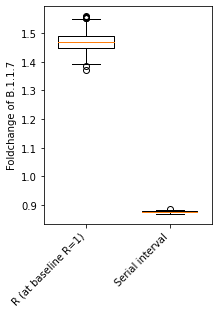

In [38]:
a0 = np.exp(svi.posterior_predictive['a0'] * 0.05)
b0 = np.exp(svi.posterior_predictive['b0'] * 0.05 * 6.5) 
plt.figure(figsize=(3,4))
plt.boxplot([b0.squeeze(), 1/a0.squeeze()], widths=.66)
plt.ylabel("Foldchange of B.1.1.7")
plt.xticks(range(1,3), labels = ["R (at baseline R=1)", "Serial interval"], 
           rotation=45, ha="right")


In [39]:
b0.shape

(1000, 1)

Text(0, 0.5, 'Foldchange serial interval')

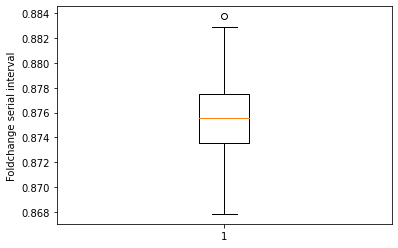

In [40]:
plt.boxplot(1/a0)
plt.ylabel("Foldchange serial interval")

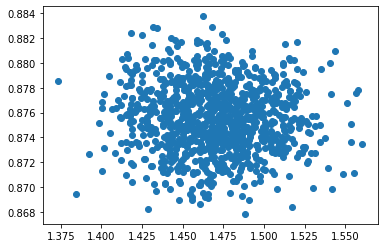

In [41]:
plt.scatter(b0 , 1/a0)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc8d20de810>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc8d0a81250>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc8d20dec90>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc8e0ca9610>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc8e0ca9110>,
 'means': []}

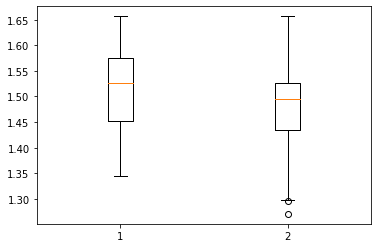

In [42]:
b = np.exp(svi.posterior_predictive['b'].mean(0) * 0.05 * 6.5)
plt.boxplot([b[w], b[~w]])
#plt.

In [43]:
np.quantile(b[w], [0.25,.5,.75])

array([1.45232445, 1.52663755, 1.57497564])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc8d40f6e90>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc8d0ce4490>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc8d40f6a10>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc8d0ce4990>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc8d0cef110>,
 'means': []}

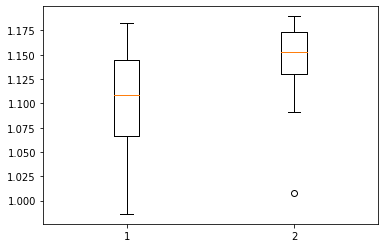

In [44]:
a = np.exp(svi.posterior_predictive['a'].mean(0) * 0.05)
plt.boxplot([a[w], a[~w]])

In [45]:
np.quantile(a[w], [0.25,.5,.75])

array([1.06619033, 1.1087904 , 1.14511672])

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


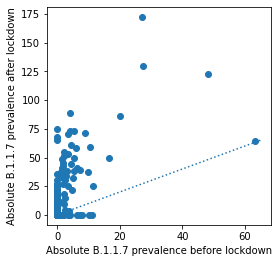

In [46]:
plt.figure(figsize=(4,4))
plt.scatter(specimen[S,65] * strain[S,6]/total[S,6], specimen[S,95] * strain[S,10]/total[S,10])
plt.xlabel("Absolute B.1.1.7 prevalence before lockdown")
plt.ylabel("Absolute B.1.1.7 prevalence after lockdown")
plt.plot([0,65],[0,65], ":")

In [47]:
s = strain + .5
t = total + 1
x = specimen[S,92] * (1- s[S,10]/t[S,10]) / (specimen[S,65] * (1-s[S,4:6].sum(1)/t[S,4:6].sum(1)) )
y = (specimen[S,92] * s[S,10]/t[S,10]) / (specimen[S,65] * s[S,4:6].sum(1)/t[S,4:6].sum(1) )

In [48]:
from scipy.stats import spearmanr
spearmanr(x[w], y[w])

SpearmanrResult(correlation=0.21691921238149262, pvalue=0.1676279252236343)

In [49]:
v = np.logical_or(np.isnan(x + y) , np.isinf(x + y + 1/y + 1/x))

In [50]:
np.corrcoef(x[~v],y[~v])

array([[1.        , 0.12317177],
       [0.12317177, 1.        ]])

Text(0.99, 0.01, 'B.1.1.7 controlled\nother escaped')

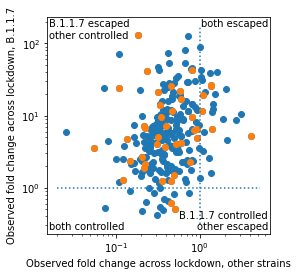

In [51]:
plt.figure(figsize=(4,4))
ax = plt.axes()
plt.loglog(x,y, "o")
plt.loglog(x[w],y[w], "o")
plt.xlabel("Observed fold change across lockdown, other strains")
plt.ylabel("Observed fold change across lockdown, B.1.1.7")
#plt.plot([3e-1, 4], [3e-1,4],":", c="C0")
plt.plot(ax.get_xlim(), [1,1],":", c="C0")
plt.plot([1, 1], ax.get_ylim(),":", c="C0")
plt.text(0.01, 0.01, 'both controlled', ha='left',va="bottom", transform=ax.transAxes)
plt.text(0.01, .99, 'B.1.1.7 escaped\nother controlled', ha='left',va="top", transform=ax.transAxes)
plt.text(0.99, 0.99, 'both escaped', ha='right',va="top", transform=ax.transAxes)
plt.text(0.99, 0.01, 'B.1.1.7 controlled\nother escaped', ha='right',va="bottom", transform=ax.transAxes)

In [52]:
import geopandas as gpd

In [53]:
LAD

,objectid,pop18,lad19cd,lad19nm,lad19id,utla19cd,utla19nm,utla19id,ctry19cd,ctry19nm,ctry19id,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,93242,E06000001,Hartlepool,0,E06000001,Hartlepool,0,E92000001,England,0,447160,531474,-1.27018,54.676140,9.371262e+07,71011.933949,"MULTIPOLYGON (((447213.900 537036.104, 447228...."
1,2,140545,E06000002,Middlesbrough,1,E06000002,Middlesbrough,0,E92000001,England,0,451141,516887,-1.21099,54.544670,5.388156e+07,44481.691242,"MULTIPOLYGON (((448609.900 521982.600, 448616...."
2,3,136718,E06000003,Redcar and Cleveland,2,E06000003,Redcar and Cleveland,0,E92000001,England,0,464361,519597,-1.00608,54.567520,2.450695e+08,96703.989701,"MULTIPOLYGON (((455932.335 527880.697, 455919...."
3,4,197213,E06000004,Stockton-on-Tees,3,E06000004,Stockton-on-Tees,0,E92000001,England,0,444940,518183,-1.30664,54.556911,2.049330e+08,123408.985928,"MULTIPOLYGON (((444157.002 527956.304, 444165...."
4,5,106566,E06000005,Darlington,4,E06000005,Darlington,0,E92000001,England,0,428029,515648,-1.56835,54.535339,1.974757e+08,107206.401677,"POLYGON ((423496.602 524724.299, 423497.204 52..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,378,93049,W06000020,Torfaen,377,W06000020,Torfaen,3,W92000004,Wales,3,327459,200480,-3.05101,51.698360,1.262399e+08,82544.775967,"POLYGON ((323898.201 211287.499, 324115.698 21..."
378,379,94142,W06000021,Monmouthshire,378,W06000021,Monmouthshire,3,W92000004,Wales,3,337812,209231,-2.90280,51.778271,8.502646e+08,224184.496320,"MULTIPOLYGON (((327830.799 231005.105, 327840...."
379,380,153302,W06000022,Newport,379,W06000022,Newport,3,W92000004,Wales,3,337897,187432,-2.89769,51.582310,1.903728e+08,153723.498020,"MULTIPOLYGON (((342211.900 194845.495, 342221...."
380,381,132447,W06000023,Powys,380,W06000023,Powys,3,W92000004,Wales,3,302329,273255,-3.43531,52.348640,5.195312e+09,610145.541416,"POLYGON ((322392.901 334017.198, 322378.002 33..."


In [54]:
mu_1 = np.array(svi.posterior['μ_strain'].mean(0)) #+ 1e-16
mu_0 = np.array(svi.posterior['μ_base'].mean(0)) #+ 1e-16

In [55]:
r_0 = mu_0[:,92]/mu_0[:,65]
r_1 = mu_1[:,92]/mu_1[:,65]

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc8d333e850>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc8d3338110>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc8d333e450>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc8d33389d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc8d3338e10>,
 'means': []}

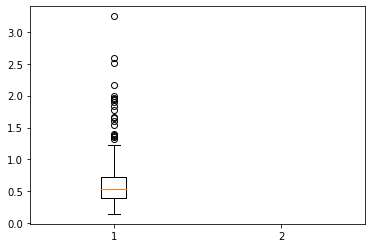

In [56]:
plt.boxplot([r_0,r_1])

In [57]:
r_1.shape

(382,)

In [58]:
np.isnan(r_1).sum()

136

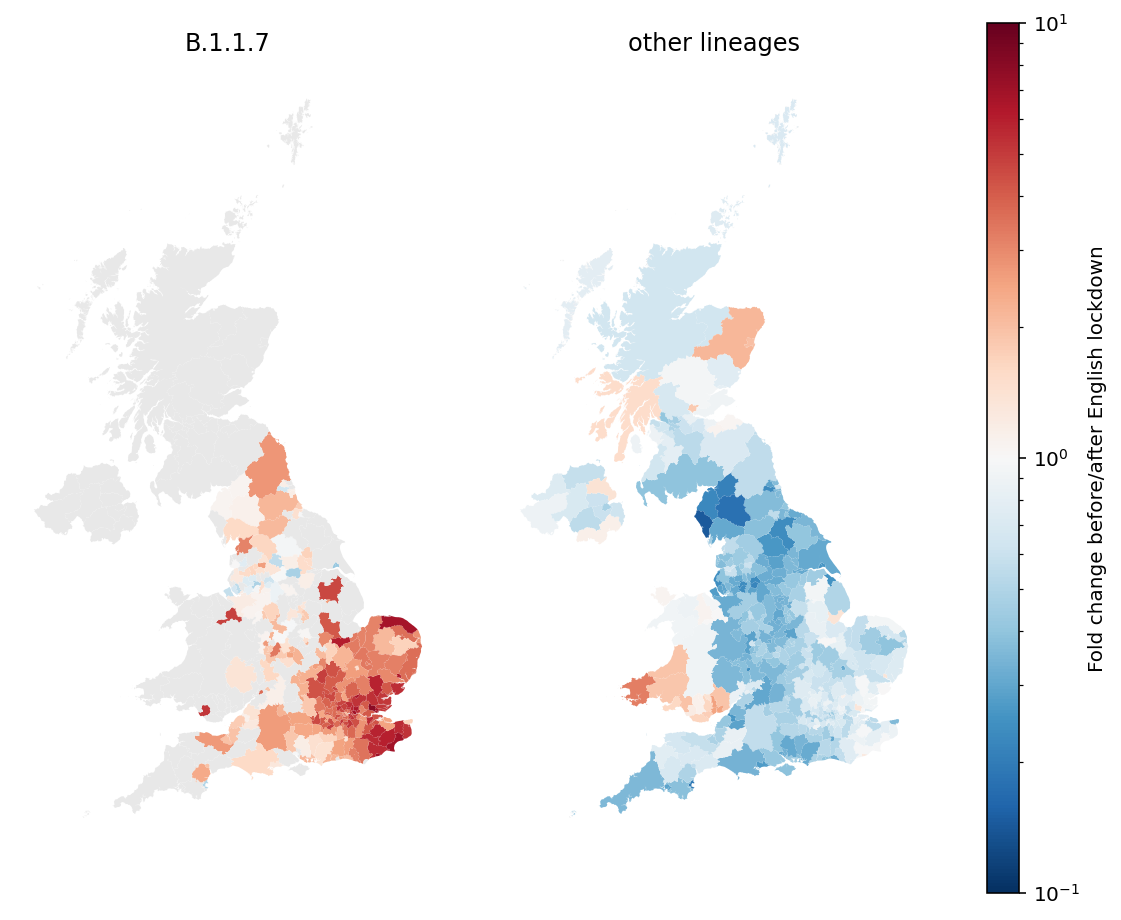

In [59]:
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format='retina'
g = LAD.copy()
g['r_0']= r_0
g['r_1'] = r_1
fig, ax = plt.subplots(1, 3, figsize=(9, 8),  gridspec_kw={'width_ratios': [10, 10, .75]}, facecolor="white")
#fig.figsize=(20,10)
#divider = make_axes_locatable(ax[1])
#cax = divider.append_axes("right", size="5%", pad=0.1)
g.plot(column='r_0', ax=ax[1], cmap="RdBu_r", norm=colors.LogNorm(vmin=0.1, vmax=10))
ax[1].set_title("other lineages")
ax[1].set_axis_off()
g.plot(column='r_1', ax=ax[0], cmap="RdBu_r", norm=colors.LogNorm(vmin=0.1, vmax=10), legend=True, cax=ax[2], 
       legend_kwds={'label': "Fold change before/after English lockdown"},
      missing_kwds={ "color": "#E8E8E8", "label": "Missing values"})
ax[0].set_title("B.1.1.7")
ax[0].set_axis_off()
#norm = colors.Normalize(vmin=-1, vmax=1)
#fig.colorbar(cm.ScalarMappable(norm=norm, cmap="RdBu"),
#             cax=ax[2], orientation='vertical', label='Fold change pre/post lockdown')


In [56]:
LAD = c19.get_geodata()
data_request = {
        "date": "date",
        "areaName": "areaName",
        "areaCode": "areaCode",
        "newPillarOneTestsByPublishDate": "newPillarOneTestsByPublishDate",
        "newCasesBySpecimenDate": "newCasesBySpecimenDate",
        "newPillarTwoTestsByPublishDate": "newPillarTwoTestsByPublishDate",
        "newPillarThreeTestsByPublishDate": "newPillarThreeTestsByPublishDate",
        "newPillarFourTestsByPublishDate": "newPillarFourTestsByPublishDate",
        "hospitalCases": "hospitalCases",
        "newDeathsByDeathDate": "newDeathsByDeathDate",
        "newCasesByPublishDate": "newCasesByPublishDate",
        "cumCasesByPublishDate": "cumCasesByPublishDate",
        "newDeathsByDeathDate": "newDeathsByDeathDate",
        "cumDeathsByDeathDate": "cumDeathsByDeathDate",
    }
newest_data = c19.get_lad_data(LAD, data_request)


In [134]:
specimen = c19.extract_covariate(newest_data, 'newCasesBySpecimenDate').T
specimen

date,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,...,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27
E06000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,61.0,32.0,40.0,71.0,67.0,65.0,35.0,18.0,27.0,NaN
E06000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.0,37.0,30.0,64.0,72.0,59.0,32.0,14.0,10.0,NaN
E06000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.0,14.0,20.0,28.0,28.0,29.0,24.0,14.0,15.0,NaN
E06000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,71.0,50.0,47.0,85.0,63.0,66.0,40.0,17.0,22.0,NaN
E06000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.0,17.0,30.0,60.0,59.0,37.0,35.0,13.0,7.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W06000020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,91.0,53.0,70.0,91.0,121.0,90.0,13.0,5.0,1.0,NaN
W06000021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.0,52.0,35.0,77.0,42.0,49.0,10.0,0.0,0.0,NaN
W06000022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,147.0,116.0,125.0,174.0,173.0,112.0,34.0,0.0,1.0,NaN
W06000023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.0,26.0,28.0,34.0,32.0,30.0,7.0,0.0,0.0,NaN


In [135]:
specimen.to_csv("newest_data/specimen-201227.csv")

In [136]:
death = c19.extract_covariate(newest_data, 'newDeathsByDeathDate').T

In [132]:
death.shape

(380, 360)

In [133]:
death.to_csv("newest_data/death-201227.csv")

In [129]:
death

,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,...,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27
lad19cd,,,,,,,,,,,,,,,,,,,,,
E06000001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,2.0,3.0,2.0,0.0,0.0,0.0,NaN
E06000002,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
E06000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,NaN
E06000004,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN
E06000005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W06000020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W06000021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W06000022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
